# Global Emissions Inequality: Spatial Autocorrelation & The Gini Coefficient

- Recap notions of global and local **spatial autocorrelation**

- **Gini Coefficient** and quasi-Gini approaches to inequality


In [5]:
#First load geopandas plus other standard libraries
#####

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns

In [6]:
#Needed for adjacency matrices

from libpysal import weights

In [7]:
#Other autocorrelation stuff:

import esda
from splot.esda import plot_moran

from splot import esda as esdaplot

In [8]:
#Some spurious warning with libpysal
import warnings
warnings.filterwarnings("ignore")

### US County Geometries and Demographics: Get Now

We'll need these later, so just grab now

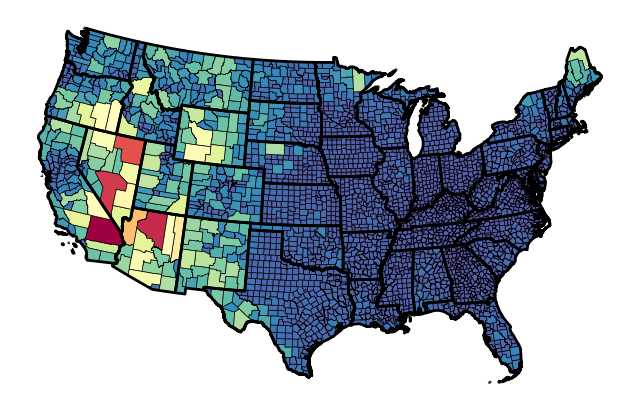

In [65]:
#Once again get County and State Geometries
################

#Load the counties and states:
#URLs:
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'

#Load:
county_gdf = gpd.read_file(url_county)
state_gdf = gpd.read_file(url_state)

## Convert CRS to North American Albers, EPSG 5070
county_gdf = county_gdf.to_crs(5070)
state_gdf = state_gdf.to_crs(5070)

#Restrict to contiguous US
exclude_list = [15, 72, 2, 60, 66, 69, 78]

#~ is not
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].astype(int).isin(exclude_list)]


#Add a FIPS code for the counties
county_gdf['FIPS'] = county_gdf.STATEFP + county_gdf.COUNTYFP


#Quick Check:
##########
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

#Draw the counties:
county_gdf.plot(ax = ax1, linewidth = .5, edgecolor = 'black', column = 'ALAND', cmap='Spectral_r')

#And the states as outline
state_gdf.plot(ax = ax1, linewidth = 2, edgecolor = 'black', facecolor = 'none')

ax1.set_axis_off()

In [66]:
### And Get Census Data Once Again
####################

#Here's our URL:
url_name = r'https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020-alldata.csv'

#Load
df = pd.read_csv(url_name, encoding = "ISO-8859-1", engine='python')

#Create the FIPS:
df['FIPS'] = df.STATE.astype(str).str.zfill(2) + df.COUNTY.astype(str).str.zfill(3)

#Merge to create gdf_county_all
gdf_county_all = county_gdf.merge(df, left_on='FIPS', right_on='FIPS', how='left')


In [67]:
#Add in population density too:
####

gdf_county_all['POPDENSITY2020'] = gdf_county_all.POPESTIMATE2020 / gdf_county_all.ALAND * 1e6

### Spatial Autocorrelation on Global Emissions

- Load our previous map of 2017 emissions

- Look at per capita emissions, and autocorrelation

In [68]:
#Look at emissions clustering:
#From before
carbon_gdf = gpd.read_file('Emissions_Map_2017/Emissions_Map_2017.shp')

In [69]:
#Let's convert to Mollweide projection! ESRI 54009
carbon_gdf = carbon_gdf.to_crs("esri:54009")


In [70]:
##Calculate per capita emissions
##########

carbon_gdf['Per_Cap'] = carbon_gdf.Total / (carbon_gdf.POP_EST + .0001)*1e3


#Get rid of unrealistic results
carbon_gdf = carbon_gdf.loc[carbon_gdf['Per_Cap'] < 1000]


#And exclude everything with population < 1,000,000
carbon_gdf = carbon_gdf.loc[carbon_gdf['POP_EST'] > 1e6]

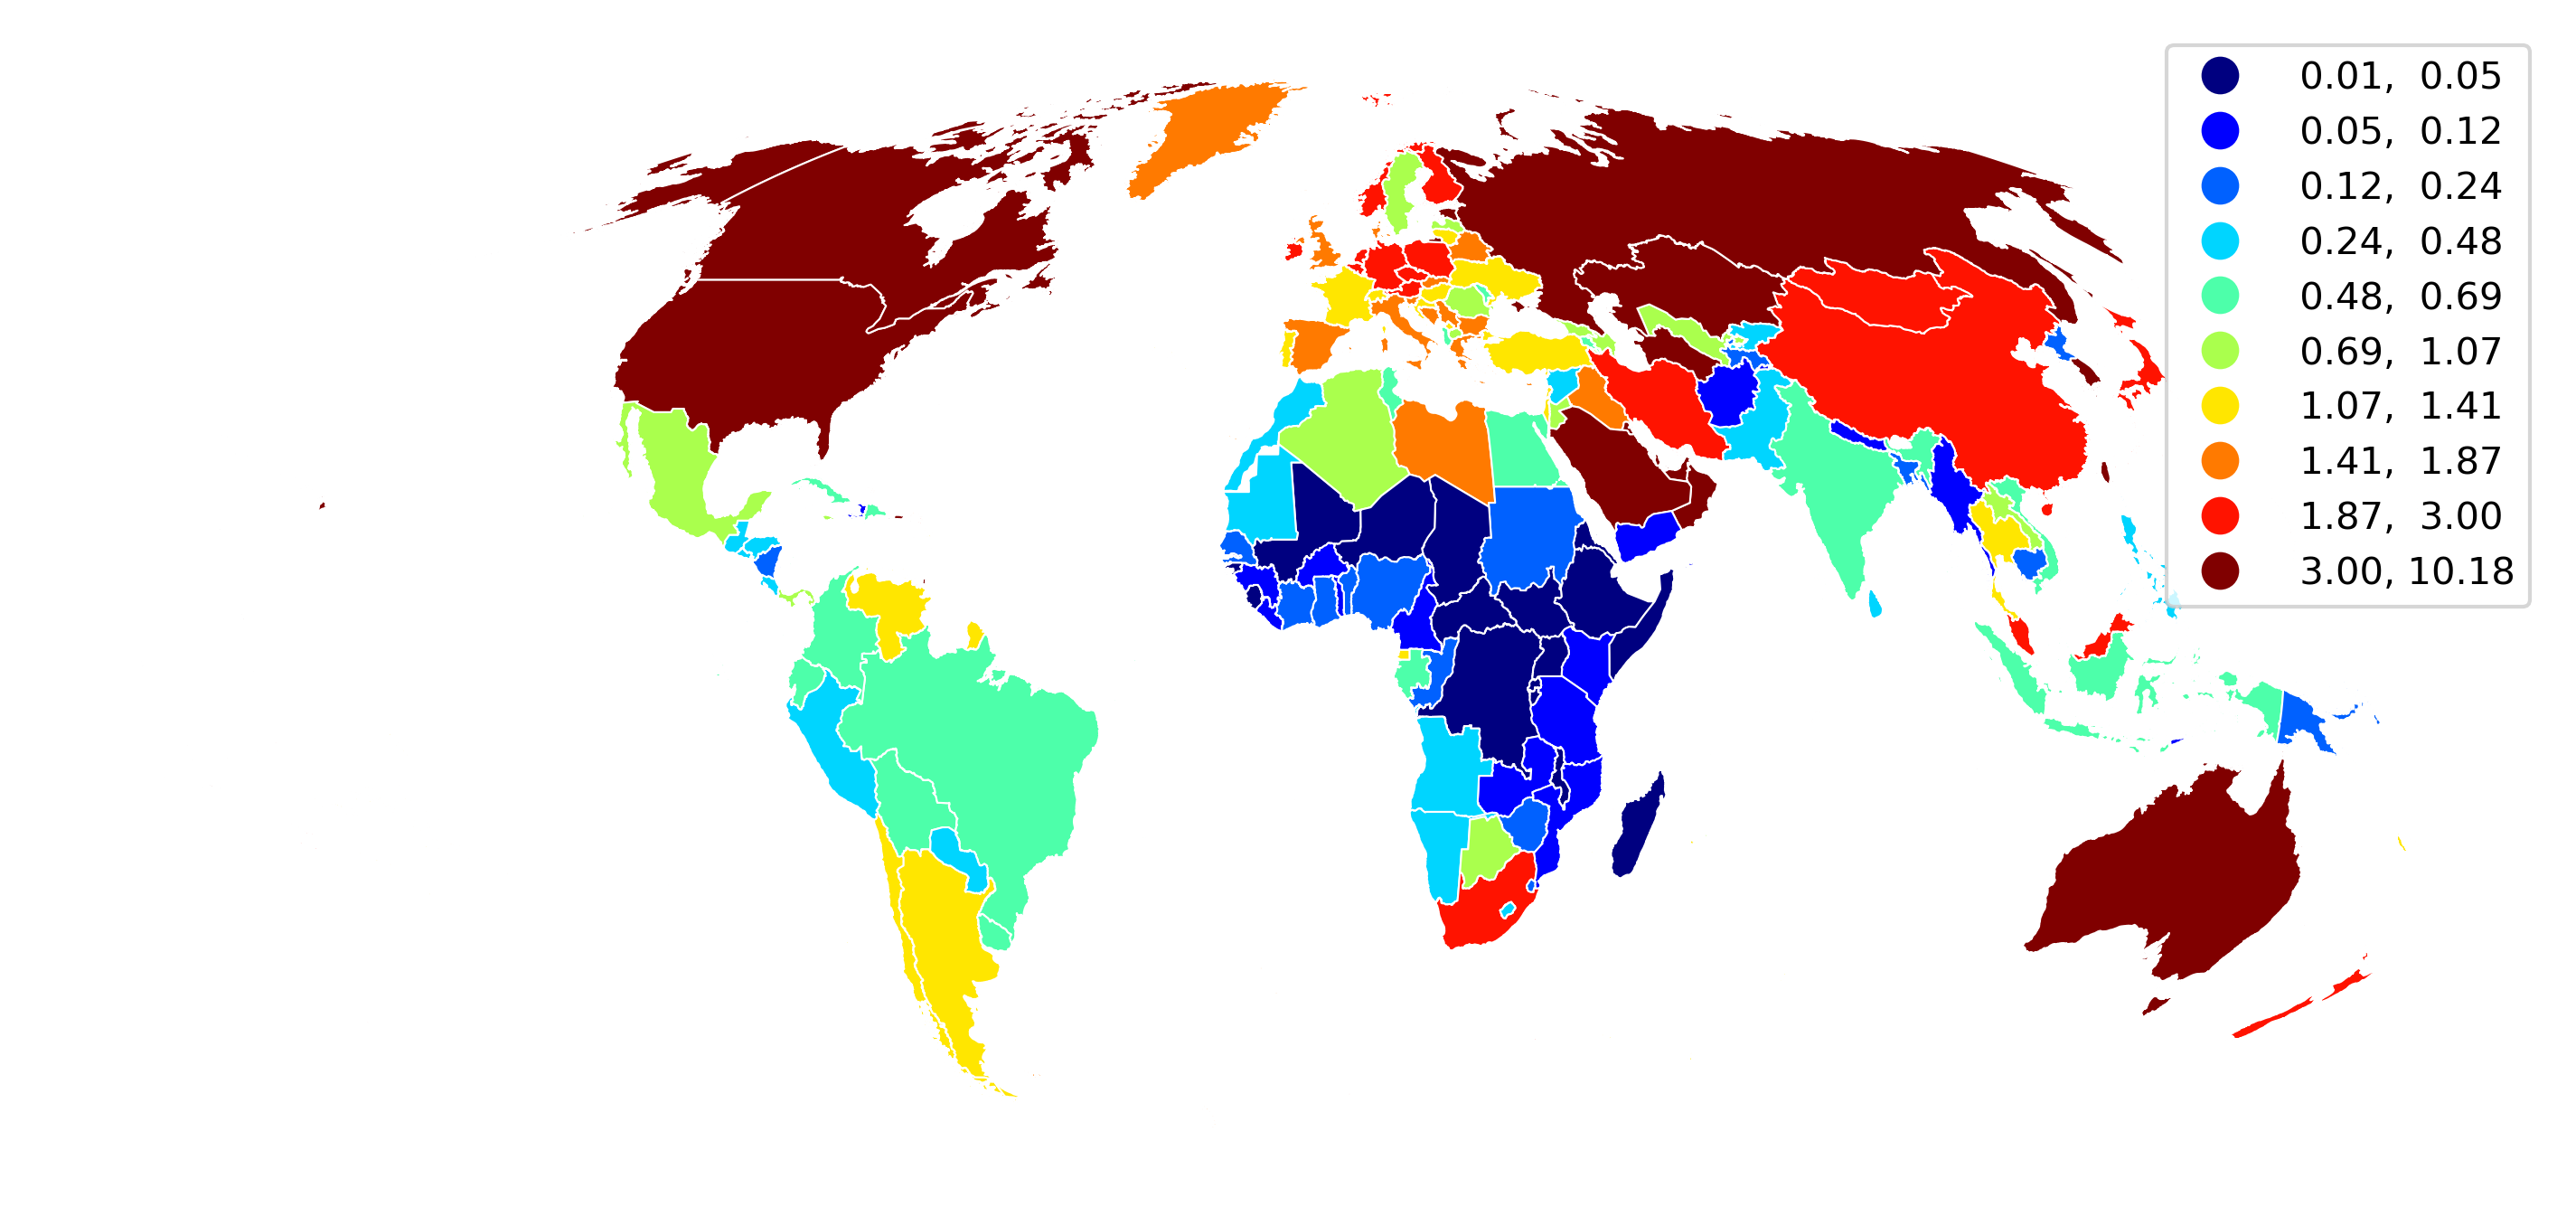

In [71]:
#Plot the per capita emissions:
#########

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=300)

carbon_gdf.plot(ax = ax1, column = 'Per_Cap', linewidth=.5,
           scheme="quantiles", k=10, cmap='jet', edgecolor='white',
           legend=True)
    
ax1.set_axis_off()


In [76]:
#Connect the countries:
########

#Get our weights matrix, we have various options...:
W = weights.distance.KNN.from_dataframe(carbon_gdf, k=8)

W = weights.distance.Kernel.from_dataframe(carbon_gdf, fixed=False, k=8)

#W = weights.distance.DistanceBand.from_dataframe(carbon_gdf, threshold=5e6)


# Row-standardization
W.transform = "R"

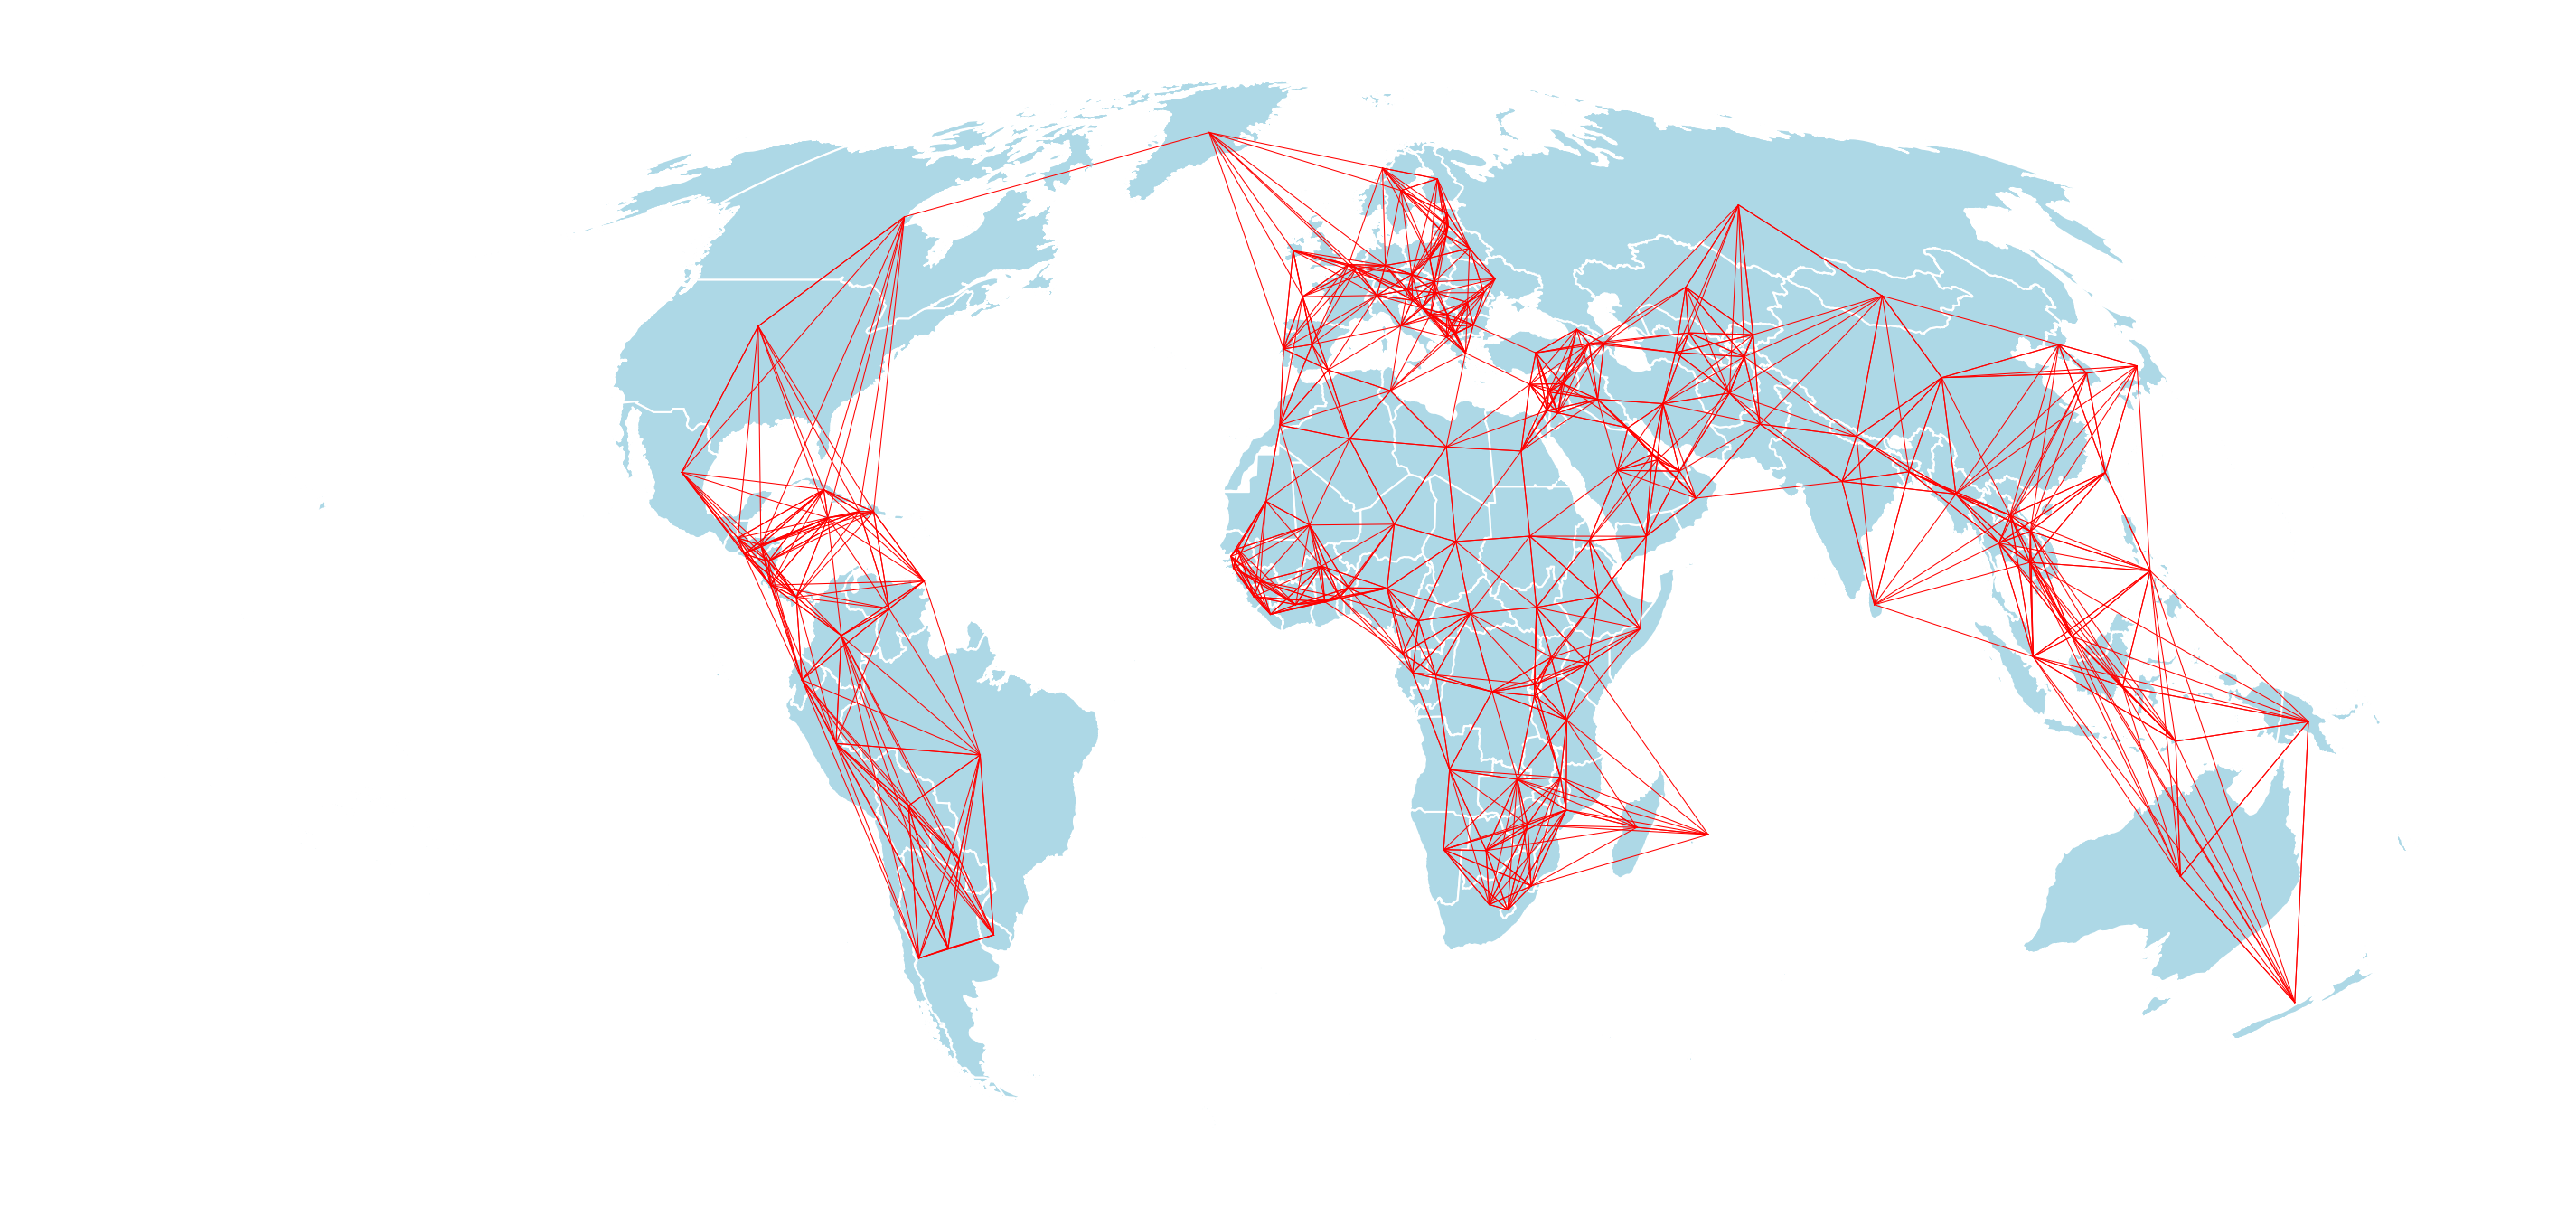

In [77]:
#Plot
#############

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=300)

carbon_gdf.plot(ax = ax1, edgecolor = 'white', linewidth=.5, facecolor='lightblue', alpha=1)
W.plot(carbon_gdf, node_kws=dict(marker=''),
                   edge_kws=dict(color="r", linestyle='-', linewidth=.25), ax=ax1)

ax1.set_axis_off()

0.6610483036382673

0.001

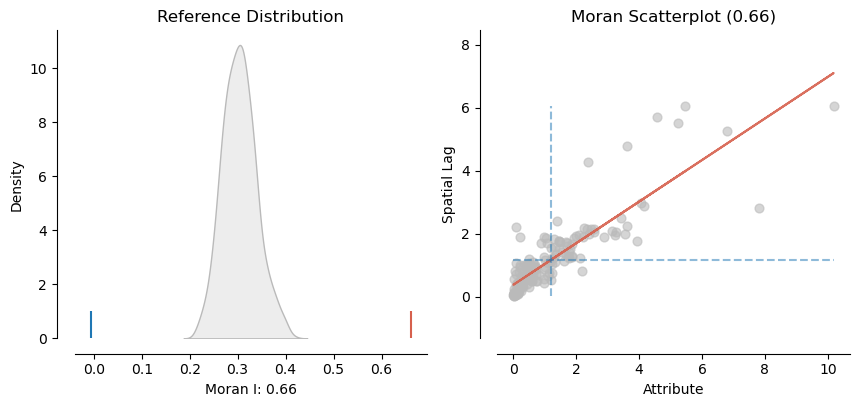

In [78]:
#Global Autocorrelation:
#########

#Just use our library methods:

moran = esda.moran.Moran(carbon_gdf["Per_Cap"], W)

display(moran.I)
display(moran.p_sim)

plot_moran(moran, zstandard=False);

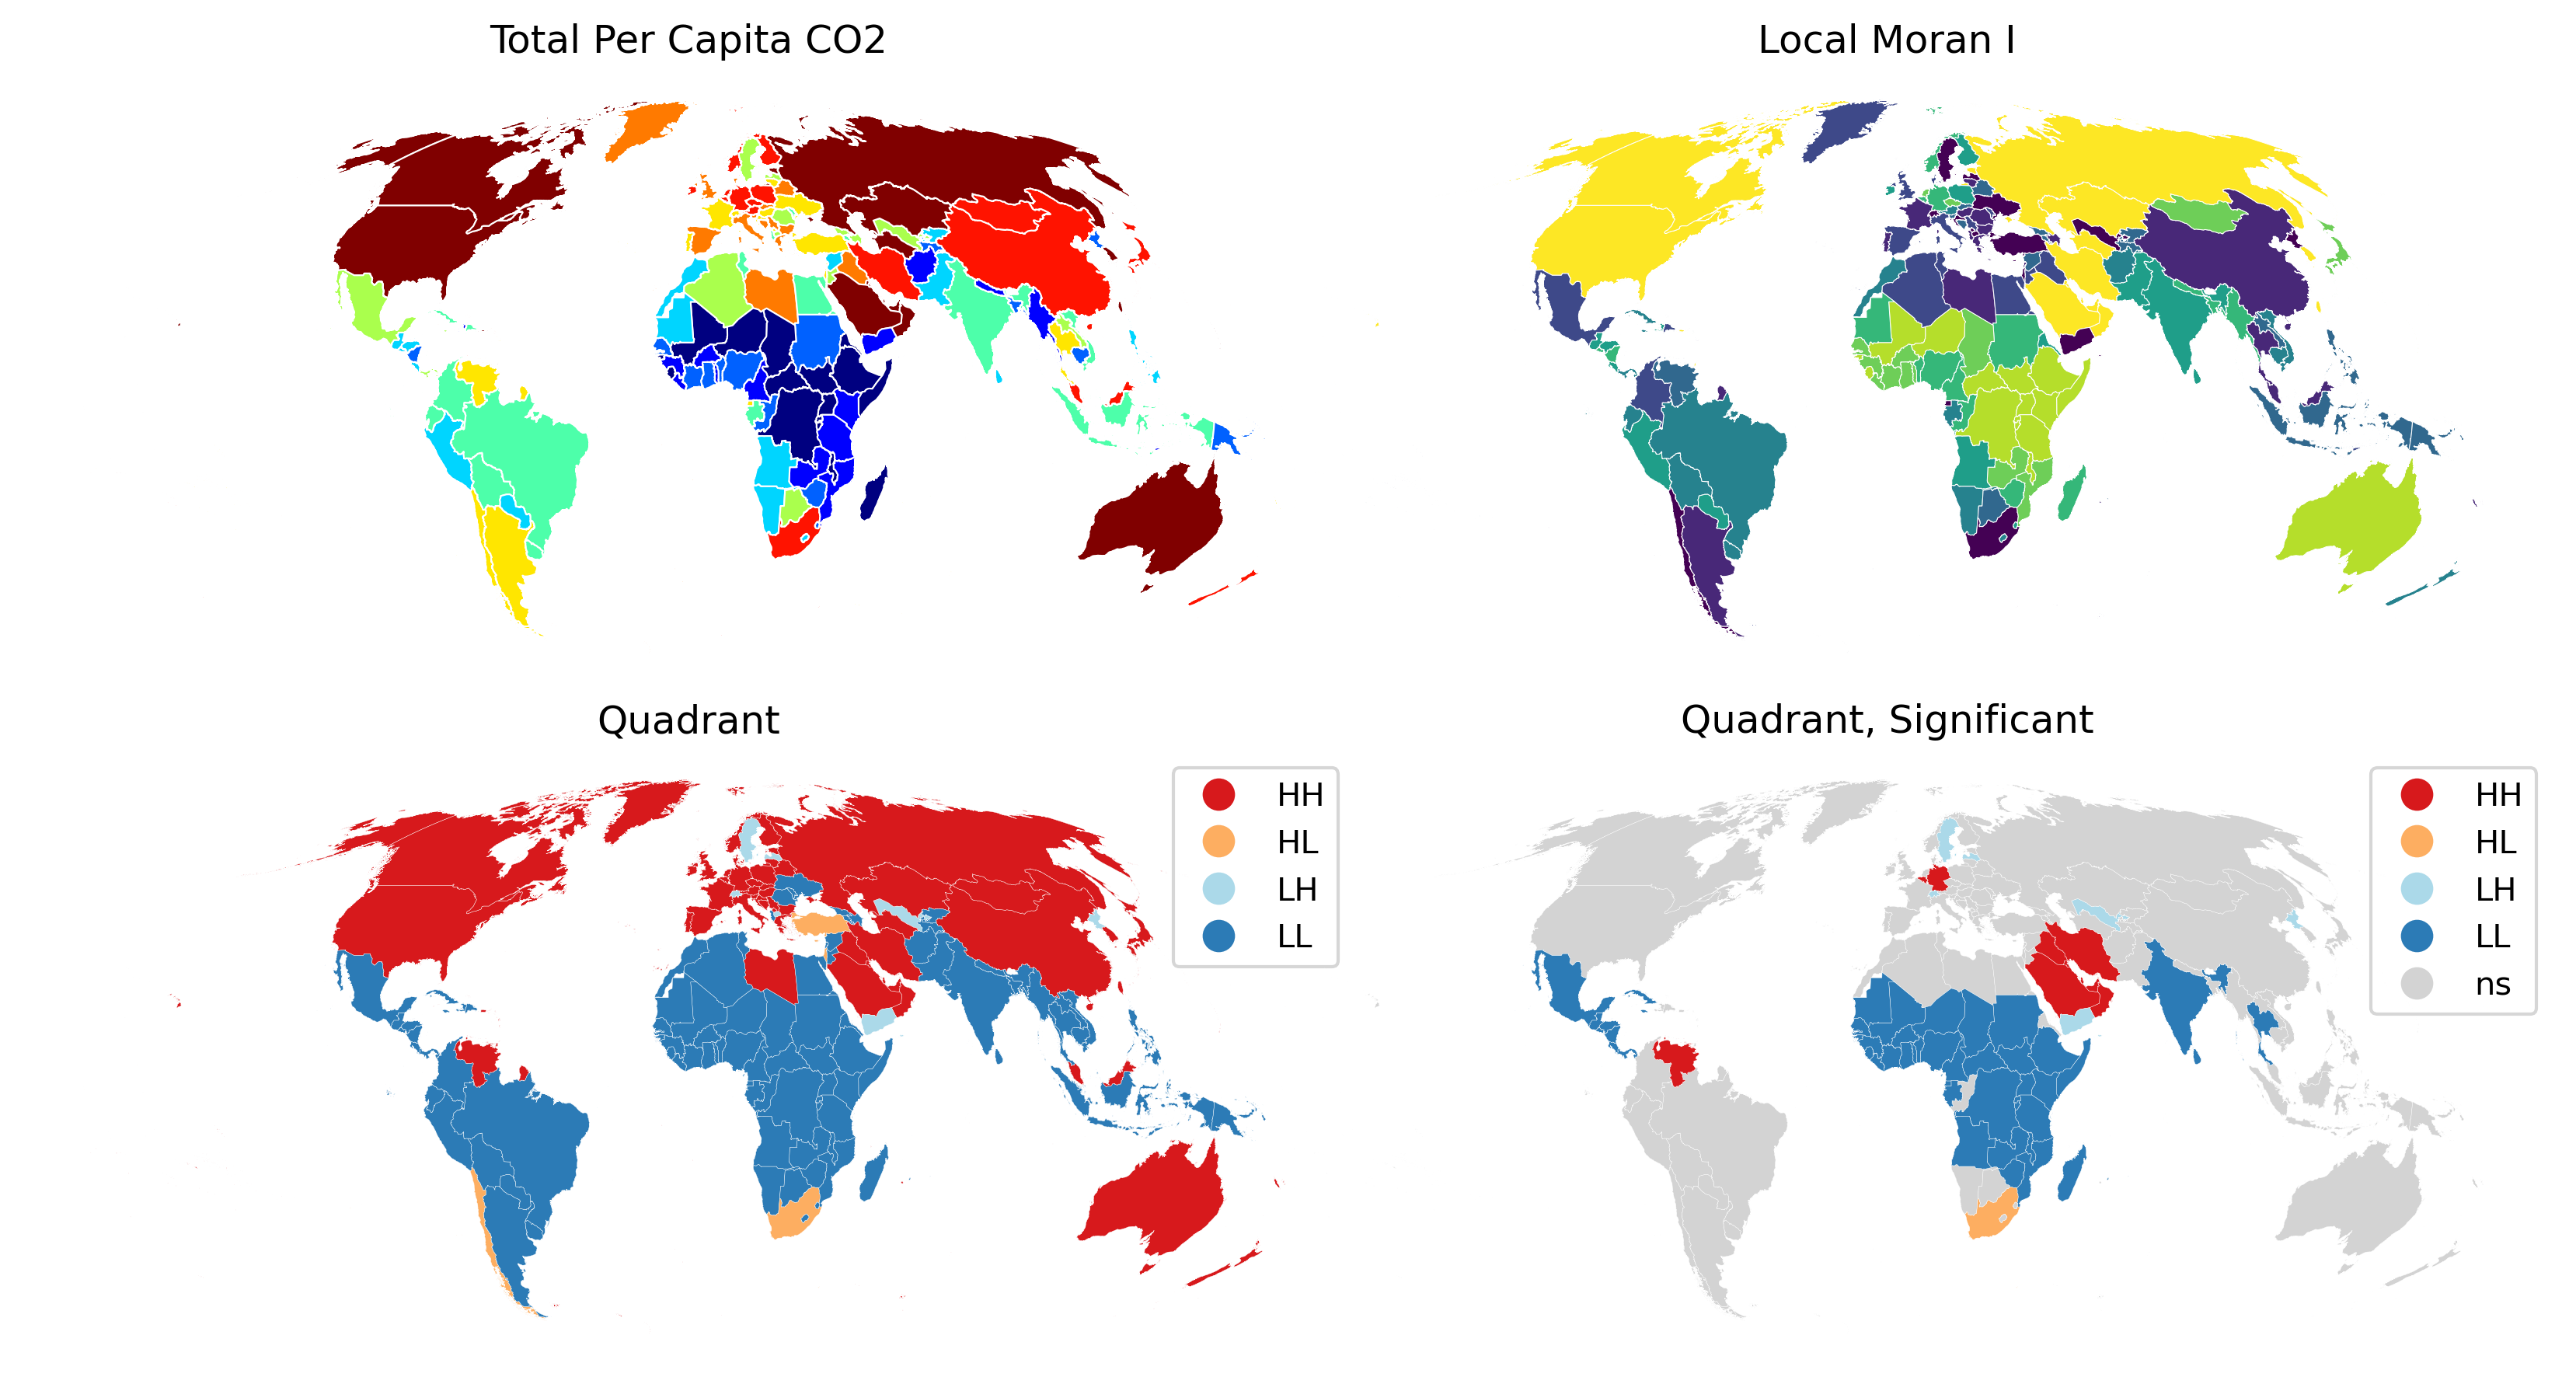

In [79]:
#Get our LISA: Moran Local I
###############

lisa = esda.moran.Moran_Local(carbon_gdf["Per_Cap"], W)

carbon_gdf['Is'] = lisa.Is


#And plot everything vs everything significant at p < .1
fig1, ax1 = plt.subplots(2,2, figsize=(14, 8), dpi=300)
ax1 = ax1.flatten()

#Emissions:
carbon_gdf.plot(ax = ax1[0], column = 'Per_Cap', linewidth=.5,
           scheme="quantiles", k=10, cmap='jet', edgecolor='white',
           legend=False)
ax1[0].set_title('Total Per Capita CO2')


#Local Moran I:
carbon_gdf.plot(column="Is", scheme="quantiles", k=10, linewidth=.25, edgecolor="white", legend=False, ax=ax1[1])
ax1[1].set_title('Local Moran I')


#Quadrant, all
esdaplot.lisa_cluster(lisa, carbon_gdf, p=1, ax=ax1[2])
ax1[2].set_title('Quadrant')


#Quadrant, significant
esdaplot.lisa_cluster(lisa, carbon_gdf, p=0.1, ax=ax1[3])
ax1[3].set_title('Quadrant, Significant')


plt.subplots_adjust(wspace=-.1, hspace=-.1)

for i in range(3):
    ax1[i].set_axis_off()

### Inequality and the Gini Coefficient

The Gini Coefficient, $G$, is a measure of inequality that is widely used to measure income inequality within societies, but can be applied to any distribution.

The Gini Coefficient is generally defined using the Lorenz curve, which plots on the horizontal axis the cumulative share of population, in order from lowest to highest income, with the cumulative share of income given on the vertical axis. A 45-degree line represents a purely equal society, while a curve bent to the right indicates some degree of inequality:

<img src="Gini2.png" width=255 />

We can define $G$ as one minus the area under the Lorenz curve ($B$) divided by the area under the line of inequality, which is simply $1/2$, giving

$$
G = 1 - \frac{B}{.5} = 1 - 2B
$$

Equivalently, $G$ is the ratio of the area between the line of equality and the Lorenz curve ($A$) to the area under the line of inequality ($A + B = 1/2$):

$$
G = \frac{A}{A+B} = 2 A
$$

For a purely equal society, $G = 0$, while $G$ approaches $1$ as a society becomes as unequal as possible. This latter case is one where, of $N$ people, $N-1$ have $0$ income and a single person has all income. In this case, $B = \frac{1}{N}$ and $G = 1 - 2/N$, which quickly approaches $1$ as $N$ gets large.

Let's construct a Lorenz curve for a population with different random income distributions...

0.11320750714572403

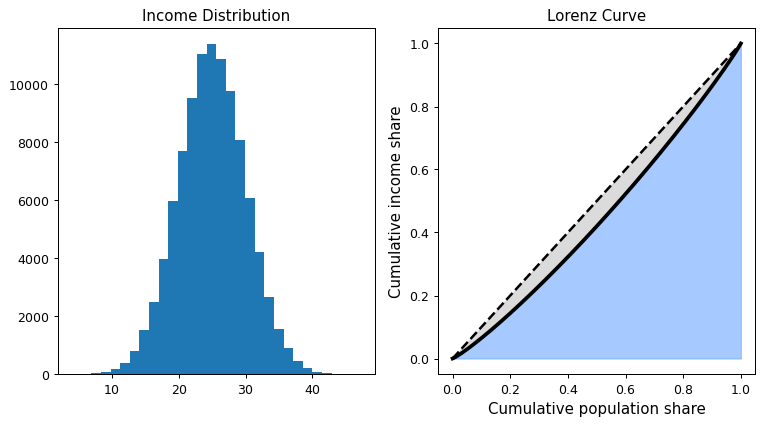

In [88]:
### Let's construct a population of N people

N = 100000

### Purely equal society:
#income = np.ones(N)

### Maximally unequal society:
#income = np.zeros(N)
#income[0] = 1

### Suppose income is uniformly distributed between 10 and 100
#income = np.random.uniform(10, 100, N)

#Or exponential:
#income = np.random.exponential(1, N)
#income = np.random.exponential(1, N)**.5

#Or:
#income = np.random.exponential(1, N)*np.random.exponential(1, N)
#income = np.random.exponential(1, N)**2

#Or Normal:
income = np.random.normal(25, 5, N)

#Now we need to sort
income.sort()


#Get the cumulative income, and the cumulative population share:
cum_income = income.cumsum()
cum_income_share = cum_income / np.sum(income)

cum_pop_share = (np.arange(1,N+1)/N)


#Make the Lorenz Curve:
fig1, ax1 = plt.subplots(1,2, figsize=(10, 5), dpi=90)

#Distribution of wealth:
#####
ax1[0].hist(income, bins=30)
ax1[0].set_title('Income Distribution')

#And the Lorenz curve
#####

ax1[1].fill_between(cum_pop_share, cum_income_share, color = (.5, .7, 1, .7))
ax1[1].fill_between(np.linspace(0,1,N), cum_income_share, np.linspace(0,1,N), color = (.8, .8, .8, .7))

ax1[1].plot(cum_pop_share, cum_income_share, linewidth=3, color='k')
ax1[1].plot([0,1], [0,1], 'k', linestyle='--', linewidth='2')

ax1[1].set_xlabel('Cumulative population share', fontsize=12)
ax1[1].set_ylabel('Cumulative income share', fontsize=12)
ax1[1].set_title('Lorenz Curve')

#Calculate Gini Coeff:
B = np.trapz(y=cum_income_share, x = cum_pop_share)

G = 1 - 2*B
display(G)

### Gini Coefficient applied to spatial dataset: County Deaths?

Want to know: How much inequality is there in the death rate among counties? Can just look at distribution of death rates, or propose a quasi-Gini approach:

1. Sort by death *rate*

2. Plot cumulative deaths against cumulative population

In [89]:
#Make a working copy
#######

gdf = gdf_county_all.copy()

In [91]:
#Sort dataset by death rate...
#"income" will be absolute deaths

N = len(gdf)

income_var = 'DEATHS2020'
sort_var = 'RDEATH2020'

gdf = gdf.sort_values(by = sort_var)

income = gdf[income_var]

#cum_pop_share = (np.arange(1,N+1)/N)
cum_pop_share = gdf['POPESTIMATE2020'].cumsum() / gdf['POPESTIMATE2020'].sum()

cum_income_share = gdf[income_var].cumsum() / gdf[income_var].sum()

0.141344696111098

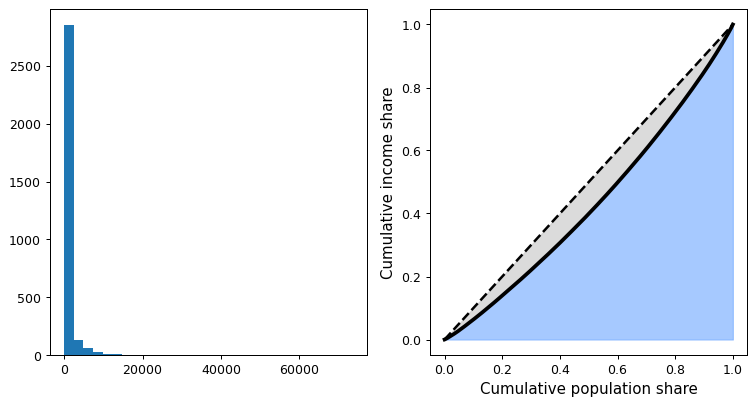

In [92]:
#Plot the Lorenz Curve:
fig1, ax1 = plt.subplots(1,2, figsize=(10, 5), dpi=90)

#Distribution of "wealth":
#####
ax1[0].hist(income, bins=30)


#And the Lorenz curve
#####

ax1[1].fill_between(cum_pop_share, cum_income_share, color = (.5, .7, 1, .7))
ax1[1].fill_between(cum_pop_share, cum_income_share, cum_pop_share, color = (.8, .8, .8, .7))

ax1[1].plot(cum_pop_share, cum_income_share, linewidth=3, color='k')
ax1[1].plot([0,1], [0,1], 'k', linestyle='--', linewidth='2')

ax1[1].set_xlabel('Cumulative population share', fontsize=12)
ax1[1].set_ylabel('Cumulative income share', fontsize=12)

#Calculate Gini Coeff:
B = np.trapz(y=cum_income_share, x = cum_pop_share)

G = 1 - 2*B

#Note, if B > 1/2, calculate as:
if (B > .5):
    G = (B - .5) * 2

G

### Do smaller (in population) counties have higher death rates? More land (relative to population)?

In [97]:
#Sort dataset by population or population density
#"income" will be absolute deaths or land area

N = len(gdf)

income_var = 'DEATHS2020'
sort_var = 'POPESTIMATE2020'

#income_var = 'ALAND'
#sort_var = 'POPESTIMATE2020' #'POPDENSITY2020'


gdf = gdf.sort_values(by = sort_var)

income = gdf[income_var]

#cum_pop_share = (np.arange(1,N+1)/N)
cum_pop_share = gdf['POPESTIMATE2020'].cumsum() / gdf['POPESTIMATE2020'].sum() #(np.arange(1,N+1)/N) #

cum_income_share = gdf[income_var].cumsum() / gdf[income_var].sum()

0.07730333381479437

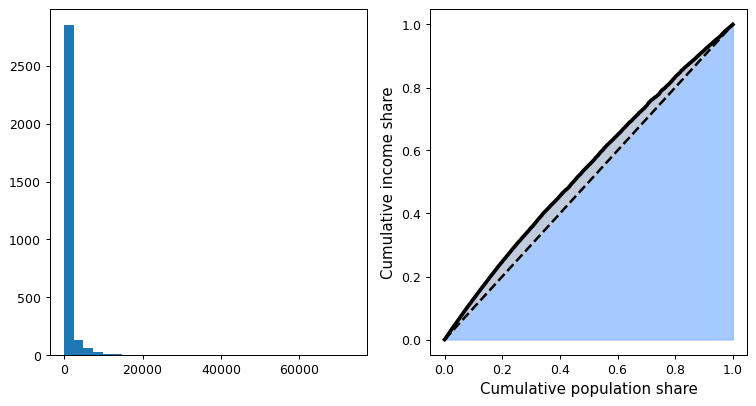

In [98]:
#Plot the Lorenz Curve again:
fig1, ax1 = plt.subplots(1,2, figsize=(10, 5), dpi=90)

#Distribution of "wealth":
#####
ax1[0].hist(income, bins=30)


#And the Lorenz curve
#####

ax1[1].fill_between(cum_pop_share, cum_income_share, color = (.5, .7, 1, .7))
ax1[1].fill_between(cum_pop_share, cum_income_share, cum_pop_share, color = (.8, .8, .8, .7))

ax1[1].plot(cum_pop_share, cum_income_share, linewidth=3, color='k')
ax1[1].plot([0,1], [0,1], 'k', linestyle='--', linewidth='2')

ax1[1].set_xlabel('Cumulative population share', fontsize=12)
ax1[1].set_ylabel('Cumulative income share', fontsize=12)

#Calculate Gini Coeff:
B = np.trapz(y=cum_income_share, x = cum_pop_share)

G = 1 - 2*B

#Note, if B > 1/2, calculate as:
if (B > .5):
    G = (B - .5) * 2

G

### Quasi-Gini Approach to Global Emissions

- Quasi-Gini approach to emissions inequality: Sort by per capita emissions, plot against cumulative sum of total emissions

- Also ask: How does population density predict emissions? Quasi-Gini Approach...

- Could also compare over time, and plot Moran's I over time (left as an exercise for the student...)

In [99]:
#Our working copy
gdf = carbon_gdf.copy()

In [103]:
#Add some more helper variables
gdf['AREA'] = gdf.area

gdf['POP_DENS'] = gdf['POP_EST'] / gdf['AREA']

#Also consider GDP:
gdf['GDP_Per_Cap'] = gdf['GDP_MD'] / gdf['POP_EST']

In [108]:
N = len(gdf)

#Emissions inequality:
income_var = 'Total' #Total emissions in 2017
sort_var = 'Per_Cap'


#Population density and emissions:
#income_var = 'Total'
#sort_var = 'POP_DENS'


#Could examine income too:
#income_var = 'GDP_MD'
#sort_var = 'GDP_Per_Cap'


gdf = gdf.sort_values(by = sort_var)

income = gdf[income_var]

#cum_pop_share = (np.arange(1,N+1)/N)
cum_pop_share = gdf['POP_EST'].cumsum() / gdf['POP_EST'].sum() #(np.arange(1,N+1)/N) #

cum_income_share = gdf[income_var].cumsum() / gdf[income_var].sum()

0.4924789271796438

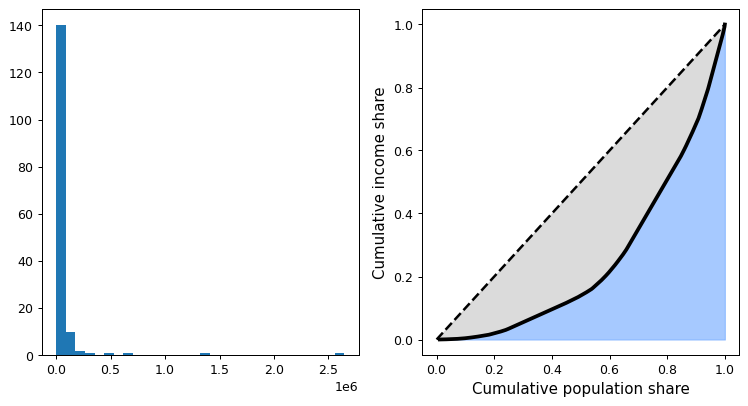

In [109]:
#Plot the Lorenz Curve:
fig1, ax1 = plt.subplots(1,2, figsize=(10, 5), dpi=90)

#Distribution of wealth:
#####
ax1[0].hist(income, bins=30)


#And the Lorenz curve
#####

ax1[1].fill_between(cum_pop_share, cum_income_share, color = (.5, .7, 1, .7))
ax1[1].fill_between(cum_pop_share, cum_income_share, cum_pop_share, color = (.8, .8, .8, .7))

ax1[1].plot(cum_pop_share, cum_income_share, linewidth=3, color='k')
ax1[1].plot([0,1], [0,1], 'k', linestyle='--', linewidth='2')

ax1[1].set_xlabel('Cumulative population share', fontsize=12)
ax1[1].set_ylabel('Cumulative income share', fontsize=12)

#Calculate Gini Coeff:
B = np.trapz(y=cum_income_share, x = cum_pop_share)

G = 1 - 2*B

#Note, if B > 1/2, calculate as:
if (B > .5):
    G = (B - .5) * 2

G

#### Zhou, B., Thies, S., Gudipudi, R., Lüdeke, M. K., Kropp, J. P., & Rybski, D. (2020). A Gini approach to spatial CO2 emissions. Plos one, 15(11), e0242479.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0242479

Data:

- Gridded Population of the World, version 4, GPWv4 1x1 km$^2$ spatial resolution in 2010
- Total anthropogenic CO$_2$ emissions from ODIAC data at 1x1 km$^2$ resolution

<img src="gini_CO2_0.png" width=850 />

<img src="gini_CO2_1.png" width=350 />

<img src="gini_CO2_2.png" width=750 />

<img src="gini_CO2_3.png" width=400 />